In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-09 04:49:22.774094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 04:49:22.856882: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 04:49:23.402746: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_084


In [2]:
oof_xgb = pd.read_csv(f'/kaggle/output/{CFG["xgb_model"]["execution"]["best_exp_id"]}/oof.csv')
oof_xgb.head()

,series_id,step,score,event
0,038441c925bb,11,-0.024772,wakeup
1,038441c925bb,11,0.032804,onset
2,038441c925bb,35,-0.021789,wakeup
3,038441c925bb,35,0.035017,onset
4,038441c925bb,59,-0.004671,wakeup


In [3]:
oof_lgb = pd.read_csv(f'/kaggle/output/{CFG["lgb_model"]["execution"]["best_exp_id"]}/oof.csv')
oof_lgb.head()

,series_id,step,score,event
0,038441c925bb,11,-0.010251,wakeup
1,038441c925bb,11,0.001311,onset
2,038441c925bb,35,-0.014163,wakeup
3,038441c925bb,35,0.004314,onset
4,038441c925bb,59,-0.011426,wakeup


In [4]:
oof_gru = pd.read_parquet(f'/kaggle/output/{CFG["patch_transformer_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_gru.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.011443,0.000096
1,05e1944c3818,18,0.007124,0.000101
2,05e1944c3818,30,0.004455,0.000113
3,05e1944c3818,42,0.003397,0.000097
4,05e1944c3818,54,0.003375,0.000085


In [5]:
oof_tubo_based = pd.read_parquet(f'/kaggle/output/tubo_based/exp019_oof.parquet')
oof_tubo_based.head()

,series_id,step,onset_oof,wakeup_oof
0,05e1944c3818,0,0.033760,0.012846
1,05e1944c3818,1,0.026779,0.009975
2,05e1944c3818,2,0.012798,0.004220
3,05e1944c3818,3,0.005708,0.001657
4,05e1944c3818,4,0.005488,0.002279


In [6]:
dfs = []
for seires_id, df_tubo_based in tqdm(oof_tubo_based.groupby("series_id")):
    df_gru = oof_gru[oof_gru["series_id"]==seires_id]
    df_xgb = oof_xgb[oof_xgb["series_id"]==seires_id]
    df_lgb = oof_lgb[oof_lgb["series_id"]==seires_id]
    df = df_tubo_based

    # tubo based
    df["onset_oof_tubo_based"] = df["onset_oof"]
    df["wakeup_oof_tubo_based"] = df["wakeup_oof"]    

    # gru
    df["onset_oof_gru"] = df["step"].map(df_gru.set_index("step")["onset_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df["wakeup_oof_gru"] = df["step"].map(df_gru.set_index("step")["wakeup_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # xgb
    xgb_wakeup = df_xgb[df_xgb["event"]=="wakeup"]
    df["wakeup_oof_xgb"] = df["step"].map(xgb_wakeup.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    xgb_onset = df_xgb[df_xgb["event"]=="onset"]
    df["onset_oof_xgb"] = df["step"].map(xgb_onset.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # lgb
    lgb_wakeup = df_lgb[df_lgb["event"]=="wakeup"]
    df["wakeup_oof_lgb"] = df["step"].map(lgb_wakeup.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    lgb_onset = df_lgb[df_lgb["event"]=="onset"]
    df["onset_oof_lgb"] = df["step"].map(lgb_onset.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    
    df["wakeup_oof"] = df["wakeup_oof_gru"] * 0.4 + df["wakeup_oof_xgb"] * 0.15 + df["wakeup_oof_lgb"] * 0.15 * df["wakeup_oof_tubo_based"] * 0.3
    df["onset_oof"] = df["onset_oof_gru"] * 0.4 + df["onset_oof_xgb"] * 0.15 + df["onset_oof_lgb"] * 0.15 * df["onset_oof_tubo_based"] * 0.3

    # df["wakeup_oof"] = df["wakeup_oof_gru"] * 0.6 + df["wakeup_oof_xgb"] * 0.2 + df["wakeup_oof_lgb"] * 0.2 * df["wakeup_oof_tubo_based"] * 0
    # df["onset_oof"] = df["onset_oof_gru"] * 0.6 + df["onset_oof_xgb"] * 0.2 + df["onset_oof_lgb"] * 0.2 * df["onset_oof_tubo_based"] * 0

    df = df[["series_id", "step", "wakeup_oof", "onset_oof"]].reset_index(drop=True)
    dfs.append(df)
oof_df = pd.concat(dfs)
oof_df = oof_df[oof_df["step"] % 12 == 6]
del dfs
gc.collect()

100%|██████████| 277/277 [03:51<00:00,  1.20it/s]


13

1159865

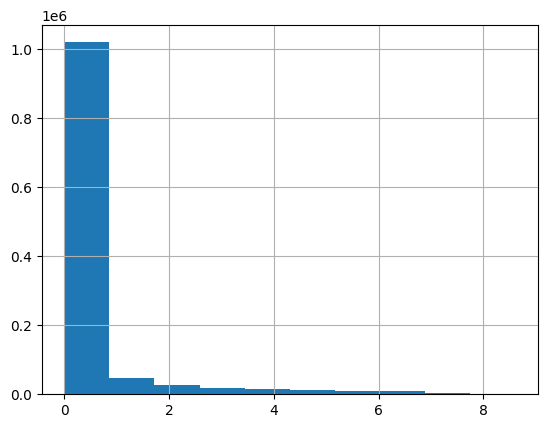

In [7]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.005]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.005]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["score"].hist()
len(train)

In [8]:
from multiprocessing import Pool

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:05<00:00, 47.57it/s]


In [9]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.8122


event   tolerance
onset   12           0.419526
        36           0.740699
        60           0.814850
        90           0.844122
        120          0.866217
        150          0.876393
        180          0.887670
        240          0.898575
        300          0.903735
        360          0.909639
wakeup  12           0.391632
        36           0.736568
        60           0.809710
        90           0.834795
        120          0.857070
        150          0.865714
        180          0.878320
        240          0.891743
        300          0.904179
        360          0.912886
dtype: float64